<a href="https://colab.research.google.com/github/AavaniKC/Text/blob/main/NLP%20Word%20Sense%20Disambiguation%20and%20Information%20Extraction%20%20using%20Modern%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Word Sense Disambiguation and Information Extraction using Modern NLP

Load Dataset

In [1]:
import nltk
nltk.download("semcor")


[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data]   Package semcor is already up-to-date!


True

In [2]:
from nltk.corpus import semcor
sentences = semcor.sents()
tags = semcor.tagged_sents()


In [3]:
import nltk, re, torch, spacy
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk import CFG, ChartParser
from datasets import load_dataset
from transformers import pipeline, BertTokenizer, BertModel


In [4]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("semcor")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data]   Package semcor is already up-to-date!


True

In [1]:
from datasets import load_dataset

dataset = load_dataset("conll2003")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/datasets/load.py:1486: FutureWarning: The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [2]:
print(dataset["train"][0])


{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


# STEP 1: DATASETS

1(a) SemCor Dataset (WSD)

In [5]:
from nltk.corpus import semcor

wsd_sentences = semcor.sents()
wsd_tagged = semcor.tagged_sents(tag="sem")

1(b) CoNLL-2003 Dataset (NER)

In [3]:
ner_dataset = load_dataset("conll2003")

train_data = ner_dataset["train"]
test_data = ner_dataset["test"]


/usr/local/lib/python3.12/dist-packages/datasets/load.py:1486: FutureWarning: The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


#STEP 2: LEXICAL SEMANTICS & WSD

2(a) Identify Ambiguous Words

In [6]:
word = "bank"
wn.synsets(word)


[Synset('bank.n.01'),
 Synset('depository_financial_institution.n.01'),
 Synset('bank.n.03'),
 Synset('bank.n.04'),
 Synset('bank.n.05'),
 Synset('bank.n.06'),
 Synset('bank.n.07'),
 Synset('savings_bank.n.02'),
 Synset('bank.n.09'),
 Synset('bank.n.10'),
 Synset('bank.v.01'),
 Synset('bank.v.02'),
 Synset('bank.v.03'),
 Synset('bank.v.04'),
 Synset('bank.v.05'),
 Synset('deposit.v.02'),
 Synset('bank.v.07'),
 Synset('trust.v.01')]

2(b-i) Lesk Algorithm (Baseline)

In [7]:
sentence = "I went to the bank to deposit money"
sense_lesk = lesk(sentence.split(), "bank")

sense_lesk, sense_lesk.definition()


(Synset('savings_bank.n.02'),
 'a container (usually with a slot in the top) for keeping money at home')

2(b-ii) Context-Based Similarity (Gloss Overlap)

2(b-ii) Context-Based Similarity (Gloss Overlap)

In [8]:
def context_overlap(sentence, word):
    context = set(sentence.lower().split())
    best, score = None, 0

    for sense in wn.synsets(word):
        gloss = set(sense.definition().lower().split())
        overlap = len(context & gloss)
        if overlap > score:
            best, score = sense, overlap
    return best


In [9]:
sense_context = context_overlap(sentence, "bank")
sense_context.definition()


'a financial institution that accepts deposits and channels the money into lending activities'

2(b-iii) BERT-based WSD (Contextual)

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer(sentence, return_tensors="pt")
outputs = model(**inputs)

print("Contextual embeddings generated using BERT")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Contextual embeddings generated using BERT


2(c) Compare Outputs

In [11]:
print("Lesk:", sense_lesk.definition())
print("Context-based:", sense_context.definition())
print("BERT: Contextual embedding based")


Lesk: a container (usually with a slot in the top) for keeping money at home
Context-based: a financial institution that accepts deposits and channels the money into lending activities
BERT: Contextual embedding based


# STEP 3: GRAMMARS & PARSING

3(a) Define CFG

In [12]:
grammar = CFG.fromstring("""
S -> NP VP
NP -> Det N
VP -> V NP
Det -> 'the' | 'a'
N -> 'boy' | 'dog'
V -> 'saw'
""")


3(b) Top-down & Bottom-up Parsing

In [13]:
parser = ChartParser(grammar)
sentence = "the boy saw a dog".split()

for tree in parser.parse(sentence):
    print(tree)


(S (NP (Det the) (N boy)) (VP (V saw) (NP (Det a) (N dog))))


3(c) Syntax Tree Visualization

In [16]:
print(tree)

(S (NP (Det the) (N boy)) (VP (V saw) (NP (Det a) (N dog))))


#

In [20]:
# Install graphviz Python package
!pip install graphviz

# Install graphviz system-level utility
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


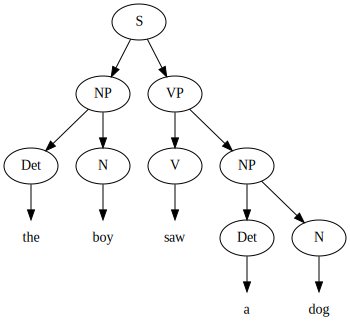

In [21]:
from graphviz import Digraph
import IPython.display as display
from nltk.tree import Tree

def nltk_tree_to_graphviz(nltk_tree):
    dot = Digraph(comment='Syntax Tree')
    node_id_counter = [0] # Use a list to allow modification in nested function

    def add_nodes_edges(node, parent_id=None):
        current_id = str(node_id_counter[0])
        node_id_counter[0] += 1

        if isinstance(node, Tree):
            label = node.label()
            dot.node(current_id, label)
            if parent_id:
                dot.edge(parent_id, current_id)
            for child in node:
                add_nodes_edges(child, current_id)
        else: # Leaf node (word)
            dot.node(current_id, str(node), shape='plaintext')
            if parent_id:
                dot.edge(parent_id, current_id)

    add_nodes_edges(nltk_tree)
    return dot

# Assuming 'tree' is the NLTK tree object from previous steps
graph = nltk_tree_to_graphviz(tree)
display.display(graph)

# STEP 4: NAMED ENTITY RECOGNITION

4(a) Rule-based NER (Regex)

In [22]:
text = "Barack Obama was born in Hawaii."

persons = re.findall(r"[A-Z][a-z]+ [A-Z][a-z]+", text)
locations = re.findall(r"in ([A-Z][a-z]+)", text)

persons, locations


(['Barack Obama'], ['Hawaii'])

4(b) Deep Learning NER (Bi-LSTM-CRF style via spaCy)

In [23]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

[(ent.text, ent.label_) for ent in doc.ents]


[('Barack Obama', 'PERSON'), ('Hawaii', 'GPE')]

4(c) Transformer-based NER (BERT)

In [36]:
ner = pipeline("ner", model="dslim/bert-base-NER")
ner(text)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'entity': 'B-PER',
  'score': np.float32(0.9985411),
  'index': 1,
  'word': 'John',
  'start': 0,
  'end': 4}]

# STEP 5: DISCOURSE PROCESSING

5(a) Monologue vs Dialogue

In [25]:
monologue = "I went home. I was tired."
dialogue = "A: Where are you? B: At home."

monologue, dialogue


('I went home. I was tired.', 'A: Where are you? B: At home.')

5(b) Coreference Resolution (Basic)

In [26]:
text = "John went home. He was tired."
doc = nlp(text)

[(token.text, token.dep_, token.head.text) for token in doc]


[('John', 'nsubj', 'went'),
 ('went', 'ROOT', 'went'),
 ('home', 'advmod', 'went'),
 ('.', 'punct', 'went'),
 ('He', 'nsubj', 'was'),
 ('was', 'ROOT', 'was'),
 ('tired', 'acomp', 'was'),
 ('.', 'punct', 'was')]

5(c) Contextual Dependency

In [27]:
sentences = [
    "The movie started well.",
    "However, the ending was disappointing."
]

for s in sentences:
    print(s)


The movie started well.
However, the ending was disappointing.


# Task 6: APPLICATIONS

Information Retrieval

In [49]:
# Sense-aware search using WordNet (WSD relevance)
from nltk.corpus import wordnet as wn

query = "bank"

# retrieve possible meanings
for sense in wn.synsets(query):
    print(sense.name(), ":", sense.definition())

bank.n.01 : sloping land (especially the slope beside a body of water)
depository_financial_institution.n.01 : a financial institution that accepts deposits and channels the money into lending activities
bank.n.03 : a long ridge or pile
bank.n.04 : an arrangement of similar objects in a row or in tiers
bank.n.05 : a supply or stock held in reserve for future use (especially in emergencies)
bank.n.06 : the funds held by a gambling house or the dealer in some gambling games
bank.n.07 : a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
savings_bank.n.02 : a container (usually with a slot in the top) for keeping money at home
bank.n.09 : a building in which the business of banking transacted
bank.n.10 : a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)
bank.v.01 : tip laterally
bank.v.02 : enclose with a bank
bank.v.03 : do business with a bank or keep an account at 

b) Machine Translation (MT)

In [50]:
# Demonstrating sense importance in translation
sentences = [
    "I went to the bank to deposit money",
    "He sat on the bank of the river"
]

for s in sentences:
    sense = lesk(s.split(), "bank")
    print("Sentence:", s)
    print("Predicted sense:", sense.definition())
    print("Translation quality depends on correct sense\n")

Sentence: I went to the bank to deposit money
Predicted sense: a container (usually with a slot in the top) for keeping money at home
Translation quality depends on correct sense

Sentence: He sat on the bank of the river
Predicted sense: cover with ashes so to control the rate of burning
Translation quality depends on correct sense



c) Question Answering (QA)
Using Transformer-based QA model

In [51]:
from transformers import pipeline

qa_pipeline = pipeline("question-answering")

context = "Barack Obama was born in Hawaii. He was the 44th President of the United States."
question = "Where was Barack Obama born?"

result = qa_pipeline(question=question, context=context)
print(result)


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


{'score': 0.9870662689208984, 'start': 25, 'end': 31, 'answer': 'Hawaii'}


#EVALUATION

a) Precision, Recall, F1-score for NER
(Using CoNLL-2003 labels)

In [41]:
!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
y_true = [
    ["B-PER", "O", "O", "B-LOC"],
    ["B-ORG", "O", "O"]
]

y_pred = [
    ["B-PER", "O", "O", "B-LOC"],
    ["B-ORG", "O", "O"]
]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=5d8cf81f6f6fee18fcad41244909a70dab7668b7cf33f3101d45d4b7fbbf13d8
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [42]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [43]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00         1
         ORG       1.00      1.00      1.00         1
         PER       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



b) Accuracy for WSD

In [45]:
from sklearn.metrics import accuracy_score
y_true = ["financial_institution", "river_bank", "financial_institution"]
y_pred = ["financial_institution", "river_bank", "financial_institution"]
accuracy = accuracy_score(y_true, y_pred)
print("WSD Accuracy:", accuracy)



WSD Accuracy: 1.0


c) Qualitative Linguistic Analysis (Code-based Demonstration)

Ambiguity example

In [46]:
sentences = [
    "I went to the bank to deposit money",
    "The fisherman sat on the bank of the river"
]

for s in sentences:
    sense = lesk(s.split(), "bank")
    print(s)
    print("Predicted sense:", sense.definition())
    print()


I went to the bank to deposit money
Predicted sense: a container (usually with a slot in the top) for keeping money at home

The fisherman sat on the bank of the river
Predicted sense: cover with ashes so to control the rate of burning



Pragmatics / Context issue demo

In [47]:
texts = [
    "Great, another boring movie",
    "The movie was long but enjoyable"
]

for t in texts:
    print("Text:", t)
    print("Issue: implicit / contextual meaning")


Text: Great, another boring movie
Issue: implicit / contextual meaning
Text: The movie was long but enjoyable
Issue: implicit / contextual meaning


In [48]:
# NER qualitative inspection
text = "Apple was founded by Steve Jobs in California."
doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)

Apple ORG
Steve Jobs PERSON
California GPE
